In [38]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect("../inventory.db")

sns.set_theme(style='whitegrid', font='DejaVu Sans')
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.facecolor': 'white'
})

PALETTE = ['#2C3E50','#E67E22','#27AE60','#E74C3C',
           '#8E44AD','#16A085','#D35400','#2980B9']

def fmt_dollars(v):
    if v >= 1_000_000: return f'${v/1_000_000:.1f}M'
    if v >= 1_000:     return f'${v/1_000:.1f}K'
    return f'${v:.0f}'

print("Setup complete ✅")

Setup complete ✅


In [39]:
# Cell 2 — Load the clean data
# Remember: we saved vendor_sales_summary in Phase 4
# Now we load it and apply final filters

raw_df = pd.read_sql("SELECT * FROM vendor_sales_summary", conn)
print(f"Raw rows loaded: {len(raw_df):,}")

# Apply the same filters we discussed in Phase 4:
# Only keep records where the transaction is genuinely profitable and real
df = raw_df[
    (raw_df['TotalSalesQty']     > 0) &   # product was actually sold
    (raw_df['GrossProfit']       > 0) &   # transaction made profit
    (raw_df['ProfitMargin']      > 0) &   # margin is positive
    (raw_df['ProfitMargin']      < 100)   # margin < 100% (remove anomalies)
].copy()

print(f"Clean rows after filtering: {len(df):,}")
print(f"Rows removed: {len(raw_df) - len(df):,} ({((len(raw_df)-len(df))/len(raw_df)*100):.1f}%)")

Raw rows loaded: 15
Clean rows after filtering: 15
Rows removed: 0 (0.0%)


In [40]:
# Cell 3 — Summary Statistics
# .describe() gives you count, mean, std, min, max, and quartiles
# .T transposes it so columns become rows — easier to read with many columns

print("=== SUMMARY STATISTICS ===\n")
desc = df.describe().T[['mean','std','min','25%','50%','75%','max']]
print(desc.round(2).to_string())

# KEY THINGS TO LOOK FOR IN describe():
# - mean vs median (50%) very different? → skewed data / outliers
# - std very large relative to mean? → high variance, check for outliers
# - min is negative? → possible data issue
# - max extremely high? → could be premium products or errors

=== SUMMARY STATISTICS ===

                              mean           std           min           25%           50%           75%           max
VendorNumber          1.004270e+03  3.060000e+00  1.001000e+03  1.002000e+03  1.003000e+03  1.006500e+03  1.010000e+03
Brand                 5.008000e+03  4.470000e+00  5.001000e+03  5.004500e+03  5.008000e+03  5.011500e+03  5.015000e+03
Volume                7.500000e+02  0.000000e+00  7.500000e+02  7.500000e+02  7.500000e+02  7.500000e+02  7.500000e+02
PurchasePrice         2.275333e+04  1.592679e+04  1.800000e+03  8.250000e+03  2.200000e+04  3.350000e+04  5.500000e+04
TotalPurchaseQty      3.544247e+04  8.963500e+02  3.368800e+04  3.476100e+04  3.546500e+04  3.597000e+04  3.698300e+04
TotalPurchaseDollars  8.063907e+08  5.657165e+08  6.292440e+07  2.815895e+08  7.814620e+08  1.172374e+09  1.976040e+09
TotalSalesQty         4.324447e+04  5.930300e+02  4.202100e+04  4.302200e+04  4.309100e+04  4.373400e+04  4.407900e+04
TotalSalesDollars   

In [41]:
# Cell 4 — Check for anomalies before we start charting
# Never jump straight to visualization — always interrogate the data first

print("=== NULL VALUES ===")
print(df.isnull().sum())

print("\n=== NEGATIVE VALUES CHECK ===")
print(f"Negative GrossProfit:  {(df['GrossProfit'] < 0).sum()}")
print(f"Negative ProfitMargin: {(df['ProfitMargin'] < 0).sum()}")
print(f"Zero StockTurnover:    {(df['StockTurnover'] == 0).sum()}")

print("\n=== VALUE RANGES ===")
for col in ['ProfitMargin','StockTurnover','UnitPurchasePrice']:
    print(f"{col:25s}  min={df[col].min():.2f}  max={df[col].max():.2f}  mean={df[col].mean():.2f}")

=== NULL VALUES ===
VendorNumber            0
VendorName              0
Brand                   0
Description             0
Volume                  0
PurchasePrice           0
TotalPurchaseQty        0
TotalPurchaseDollars    0
TotalSalesQty           0
TotalSalesDollars       0
AvgSalesPrice           0
FreightCost             0
GrossProfit             0
ProfitMargin            0
StockTurnover           0
UnitPurchasePrice       0
UnsoldUnits             0
UnsoldCapital           0
dtype: int64

=== NEGATIVE VALUES CHECK ===
Negative GrossProfit:  0
Negative ProfitMargin: 0
Zero StockTurnover:    0

=== VALUE RANGES ===
ProfitMargin               min=52.03  max=63.18  mean=55.11
StockTurnover              min=1.15  max=1.28  mean=1.22
UnitPurchasePrice          min=1800.00  max=55000.00  mean=22753.33


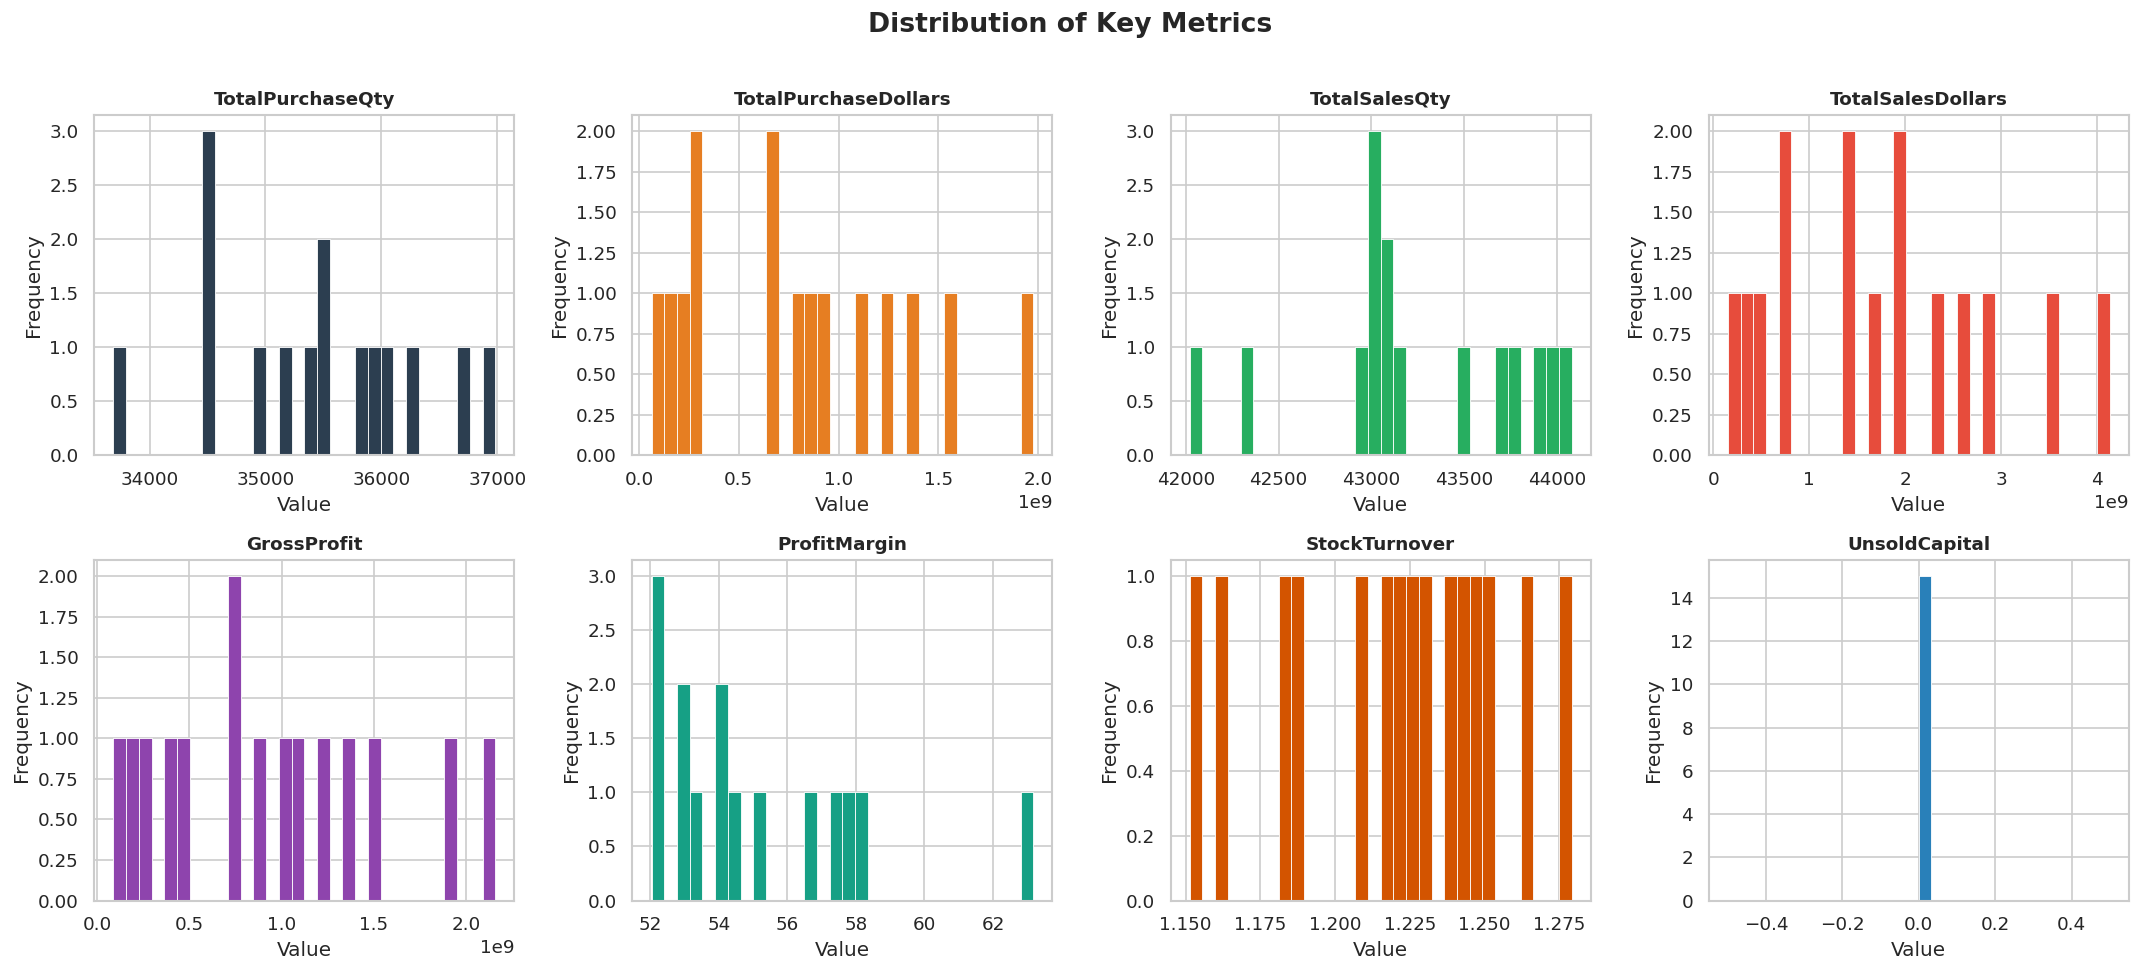

Chart saved ✅


In [42]:
# Cell 5 — Distribution Plots (Histograms)
# A histogram shows you HOW DATA IS SPREAD
# - x-axis: value ranges (bins)
# - y-axis: how many records fall in each bin
# WHY: before any analysis, you must understand your data's shape

cols_to_plot = [
    'TotalPurchaseQty', 'TotalPurchaseDollars',
    'TotalSalesQty',    'TotalSalesDollars',
    'GrossProfit',      'ProfitMargin',
    'StockTurnover',    'UnsoldCapital'
]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()  # converts 2D array of axes into 1D list — easier to loop

for i, col in enumerate(cols_to_plot):
    axes[i].hist(
        df[col].dropna(),   # drop NaN values before plotting
        bins=30,            # number of bars in histogram
        color=PALETTE[i],
        edgecolor='white',
        linewidth=0.5
    )
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

fig.suptitle('Distribution of Key Metrics', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../outputs/01_distributions.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

# WHAT TO LOOK FOR:
# - Bell curve shape → normally distributed (good for statistics)
# - Long right tail → outliers on the high end (common in price data)
# - All data in one bin → extreme outlier pulling the scale

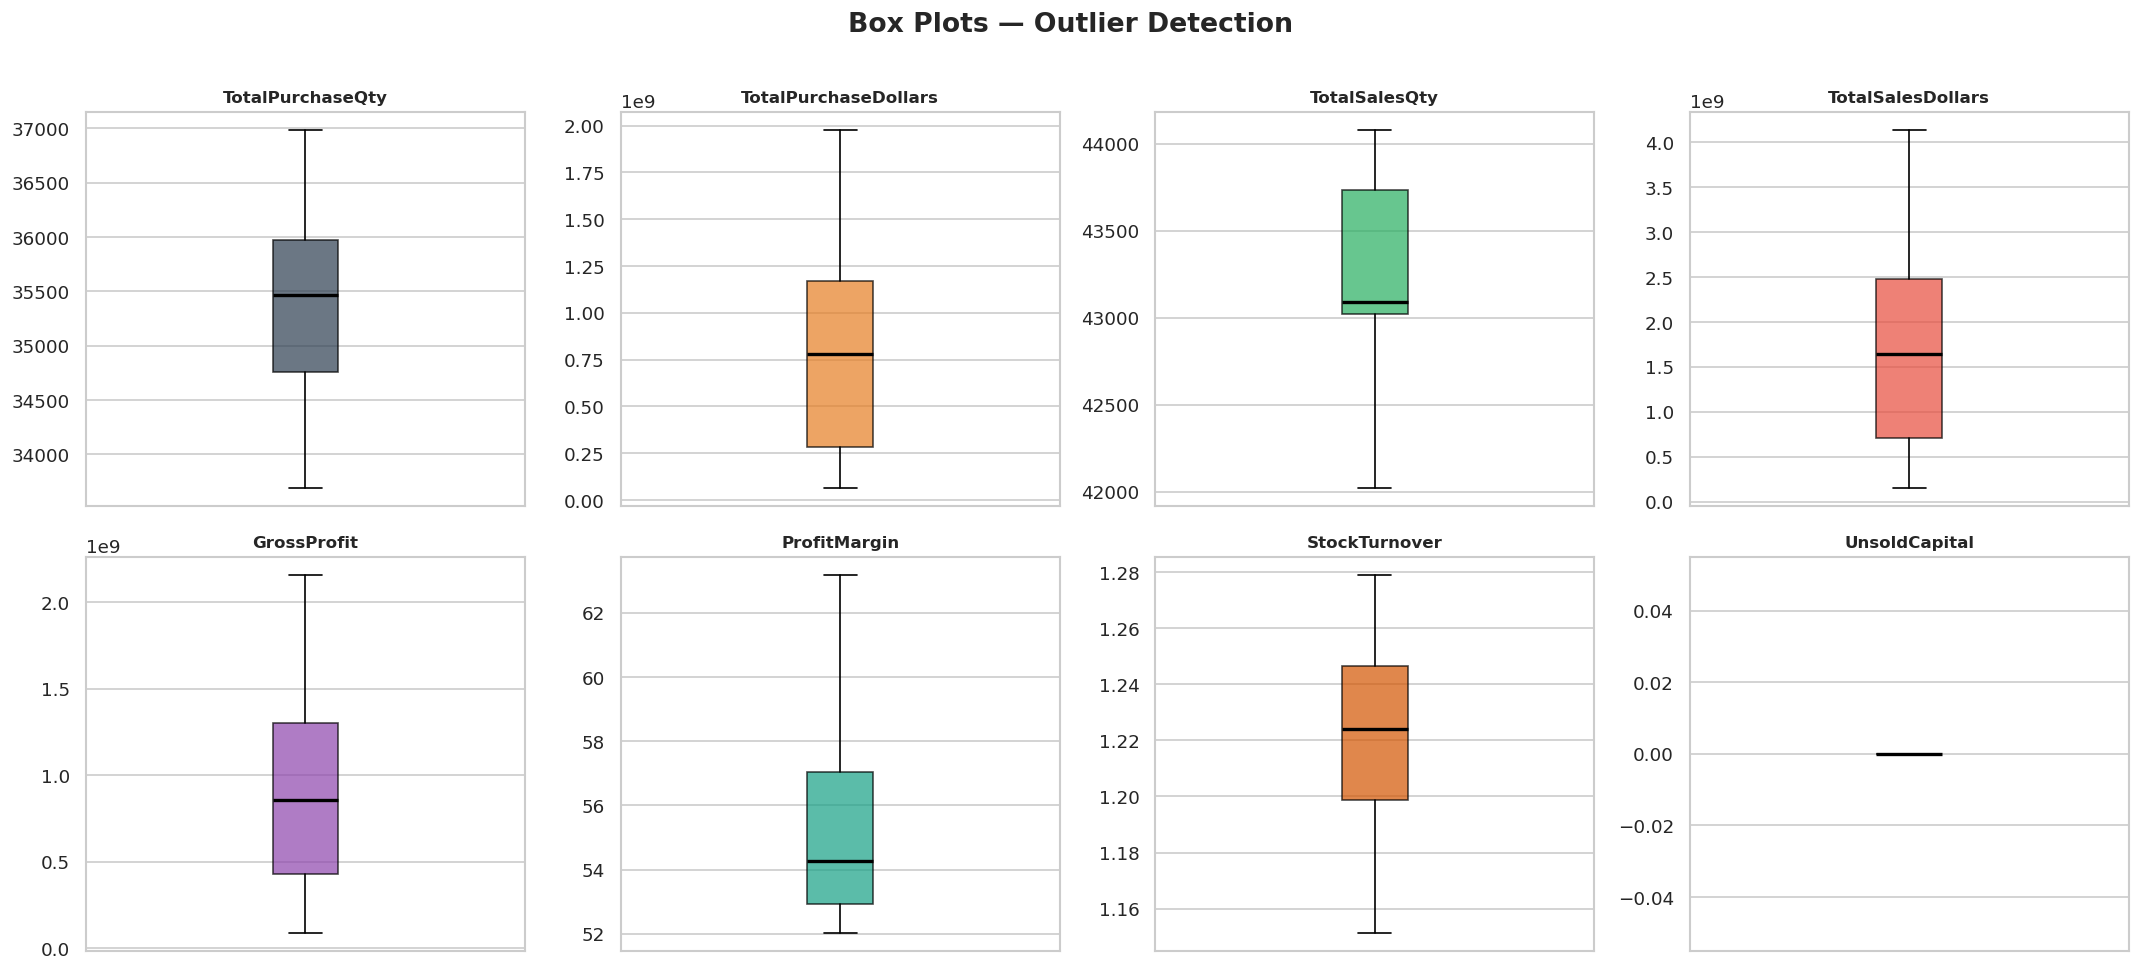

Chart saved ✅


In [43]:
# Cell 6 — Box Plots (Better for seeing outliers than histograms)
# A box plot shows:
# - The box: middle 50% of data (25th to 75th percentile)
# - Line in box: median (50th percentile)
# - Whiskers: range excluding outliers
# - Dots beyond whiskers: OUTLIERS

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    axes[i].boxplot(
        df[col].dropna(),
        patch_artist=True,          # fills the box with color
        boxprops=dict(facecolor=PALETTE[i], alpha=0.7),
        medianprops=dict(color='black', linewidth=2),
        flierprops=dict(marker='o', markersize=3, alpha=0.4)
    )
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xticks([])  # hide x-axis ticks (not needed for box plots)

fig.suptitle('Box Plots — Outlier Detection', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../outputs/02_boxplots.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

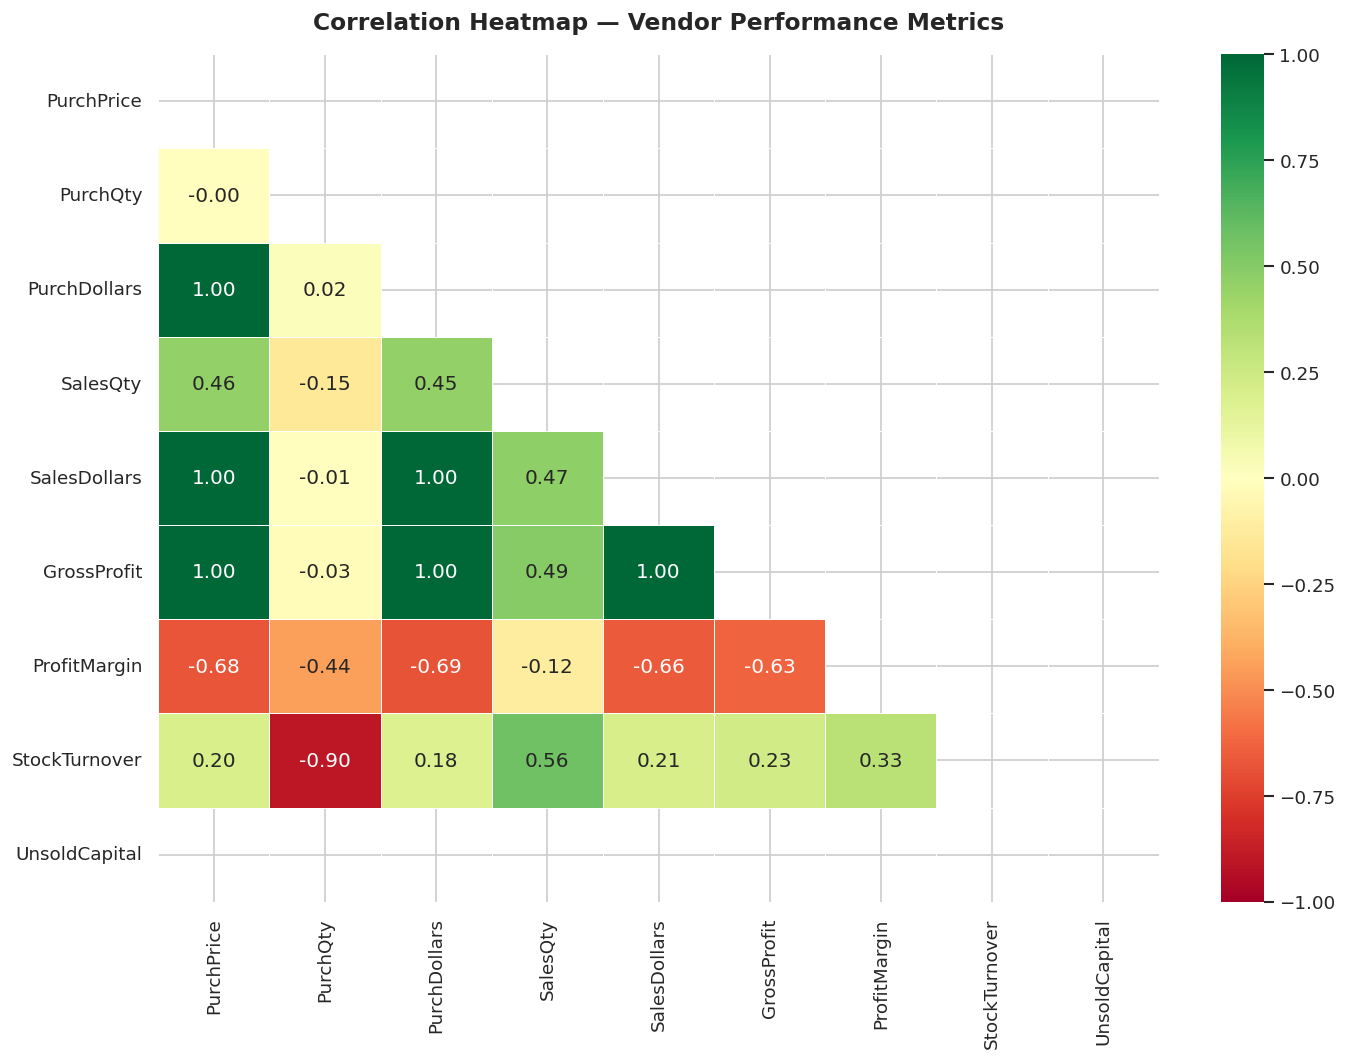

Chart saved ✅


In [44]:
# Cell 7 — Correlation Heatmap
# Correlation measures how two variables move TOGETHER
# Value ranges from -1 to +1:
#   +1 = perfect positive (one goes up, other goes up)
#    0 = no relationship
#   -1 = perfect negative (one goes up, other goes down)
# WHY: helps find which features are related, which are redundant

numeric_cols = [
    'PurchasePrice', 'TotalPurchaseQty', 'TotalPurchaseDollars',
    'TotalSalesQty', 'TotalSalesDollars', 'GrossProfit',
    'ProfitMargin',  'StockTurnover',     'UnsoldCapital'
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

# .corr() calculates pairwise correlation between all columns
corr_matrix = df[numeric_cols].corr()

# Create short labels for readability
labels = [c.replace('Total','').replace('Purchase','Purch') for c in numeric_cols]

fig, ax = plt.subplots(figsize=(12, 9))

# np.triu creates upper triangle mask — we only show bottom half
# (top half is mirror image, redundant)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,         # show correlation numbers on chart
    fmt='.2f',          # 2 decimal places
    cmap='RdYlGn',      # Red=negative, Yellow=zero, Green=positive
    vmin=-1, vmax=1,    # fix scale to -1 to 1
    ax=ax,
    linewidths=0.5,
    xticklabels=labels,
    yticklabels=labels
)

ax.set_title('Correlation Heatmap — Vendor Performance Metrics',
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('../outputs/03_correlation_heatmap.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

# READ THE HEATMAP LIKE THIS:
# Dark green = strong positive relationship
# Dark red   = strong negative relationship
# Near white = weak/no relationship

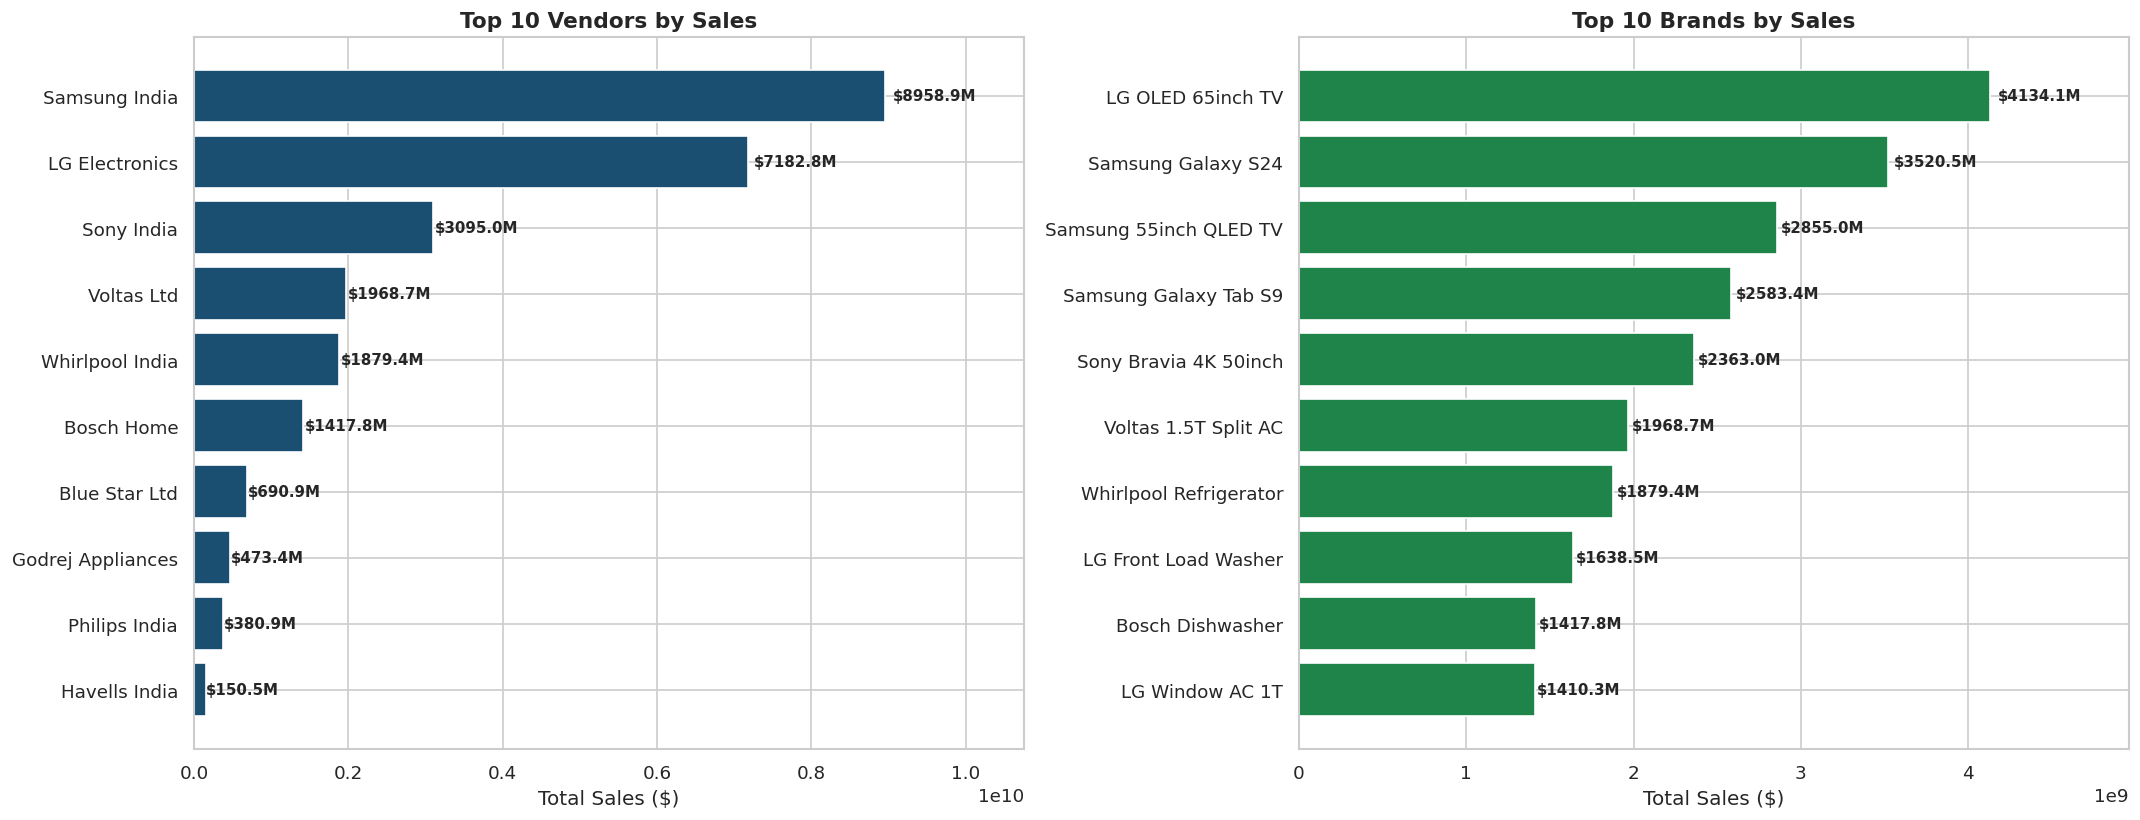

Chart saved ✅


In [45]:
# Cell 8 — Top 10 Vendors and Brands by Sales (Bar Charts)
# Research Question 2: Who are our top performers?
# Bar charts are best for RANKING and COMPARISON

# --- Aggregate: sum sales by vendor ---
top_vendors = (
    df.groupby('VendorName')['TotalSalesDollars']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# --- Aggregate: sum sales by brand/description ---
top_brands = (
    df.groupby('Description')['TotalSalesDollars']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Helper function to format large numbers readably
# 1500000 → '$1.5M',  25000 → '$25.0K'
def fmt_dollars(val):
    if val >= 1_000_000:
        return f'${val/1_000_000:.1f}M'
    elif val >= 1_000:
        return f'${val/1_000:.1f}K'
    return f'${val:.0f}'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Chart 1: Top Vendors ---
bars1 = ax1.barh(
    top_vendors['VendorName'],
    top_vendors['TotalSalesDollars'],
    color='#1B4F72',
    edgecolor='white'
)
ax1.invert_yaxis()   # highest value at top
ax1.set_xlabel('Total Sales ($)')
ax1.set_title('Top 10 Vendors by Sales', fontweight='bold', fontsize=13)

# Add value labels at end of each bar
for bar, val in zip(bars1, top_vendors['TotalSalesDollars']):
    ax1.text(
        bar.get_width() * 1.01,               # x position: just past bar end
        bar.get_y() + bar.get_height() / 2,   # y position: middle of bar
        fmt_dollars(val),
        va='center', fontsize=9, fontweight='bold'
    )
ax1.set_xlim(0, top_vendors['TotalSalesDollars'].max() * 1.2)

# --- Chart 2: Top Brands ---
bars2 = ax2.barh(
    top_brands['Description'],
    top_brands['TotalSalesDollars'],
    color='#1E8449',
    edgecolor='white'
)
ax2.invert_yaxis()
ax2.set_xlabel('Total Sales ($)')
ax2.set_title('Top 10 Brands by Sales', fontweight='bold', fontsize=13)

for bar, val in zip(bars2, top_brands['TotalSalesDollars']):
    ax2.text(
        bar.get_width() * 1.01,
        bar.get_y() + bar.get_height() / 2,
        fmt_dollars(val),
        va='center', fontsize=9, fontweight='bold'
    )
ax2.set_xlim(0, top_brands['TotalSalesDollars'].max() * 1.2)

plt.tight_layout()
plt.savefig('../outputs/04_top_performers.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

In [46]:
# Cell 9 — Target Brands Scatter Plot
# Research Question 1: Which brands need promotional intervention?
# Strategy: find brands with LOW sales BUT HIGH profit margins
# These are hidden gems — high profitability but nobody is buying them
# Solution: promotions, price cuts, sponsored placement

# Step 1: aggregate to brand level
brand_perf = (
    df.groupby('Description', as_index=False)
    .agg(
        TotalSales=('TotalSalesDollars', 'sum'),
        AvgMargin= ('ProfitMargin',      'mean')
    )
)

# I changed these from 0.15/0.85 to 0.20/0.80
# because with only 15 brands, the 15th percentile was too narrow
# and wasn't identifying enough candidates for intervention
low_sales_threshold   = brand_perf['TotalSales'].quantile(0.20)
high_margin_threshold = brand_perf['AvgMargin'].quantile(0.80)

print(f"Low sales threshold  : {fmt_dollars(low_sales_threshold)}")
print(f"High margin threshold: {high_margin_threshold:.1f}%")

# Step 3: flag target brands (both conditions must be true)
brand_perf['IsTarget'] = (
    (brand_perf['TotalSales'] < low_sales_threshold) &
    (brand_perf['AvgMargin']  > high_margin_threshold)
)

n_targets = brand_perf['IsTarget'].sum()
print(f"\nTarget brands identified: {n_targets}")

Low sales threshold  : $647.4M
High margin threshold: 57.6%

Target brands identified: 2


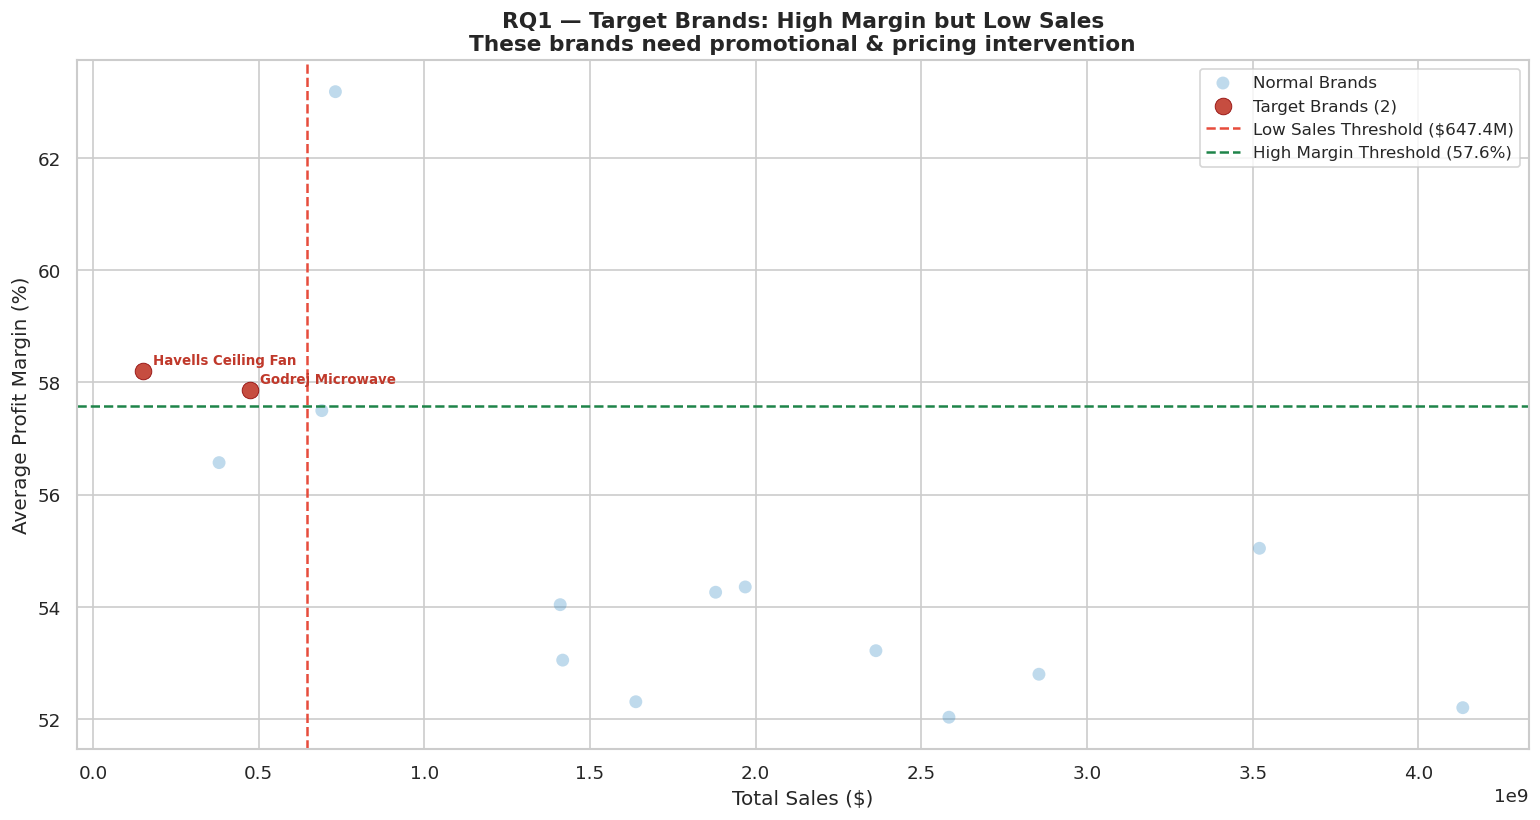

Chart saved ✅


In [47]:
# Step 4: Plot the scatter
# Each dot = one brand
# Red dots = target brands (low sales, high margin)
# Blue dots = normal brands

fig, ax = plt.subplots(figsize=(13, 7))

# Plot non-target brands first (background layer)
non_target = brand_perf[~brand_perf['IsTarget']]
ax.scatter(
    non_target['TotalSales'],
    non_target['AvgMargin'],
    color='#2E86C1', alpha=0.3, s=60,
    label='Normal Brands', edgecolors='none'
)

# Plot target brands on top (foreground layer)
target = brand_perf[brand_perf['IsTarget']]
ax.scatter(
    target['TotalSales'],
    target['AvgMargin'],
    color='#C0392B', alpha=0.9, s=100,
    label=f'Target Brands ({n_targets})', edgecolors='darkred', linewidths=0.5
)

# Annotate target brand names
for _, row in target.iterrows():
    ax.annotate(
        row['Description'],
        (row['TotalSales'], row['AvgMargin']),
        textcoords='offset points',
        xytext=(6, 4),
        fontsize=8, color='#C0392B', fontweight='bold'
    )

# Draw threshold lines
ax.axvline(low_sales_threshold,   color='#E74C3C', ls='--', lw=1.5,
           label=f'Low Sales Threshold ({fmt_dollars(low_sales_threshold)})')
ax.axhline(high_margin_threshold, color='#1E8449', ls='--', lw=1.5,
           label=f'High Margin Threshold ({high_margin_threshold:.1f}%)')

ax.set_xlabel('Total Sales ($)', fontsize=12)
ax.set_ylabel('Average Profit Margin (%)', fontsize=12)
ax.set_title(
    'RQ1 — Target Brands: High Margin but Low Sales\n'
    'These brands need promotional & pricing intervention',
    fontweight='bold', fontsize=13
)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/05_target_brands.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

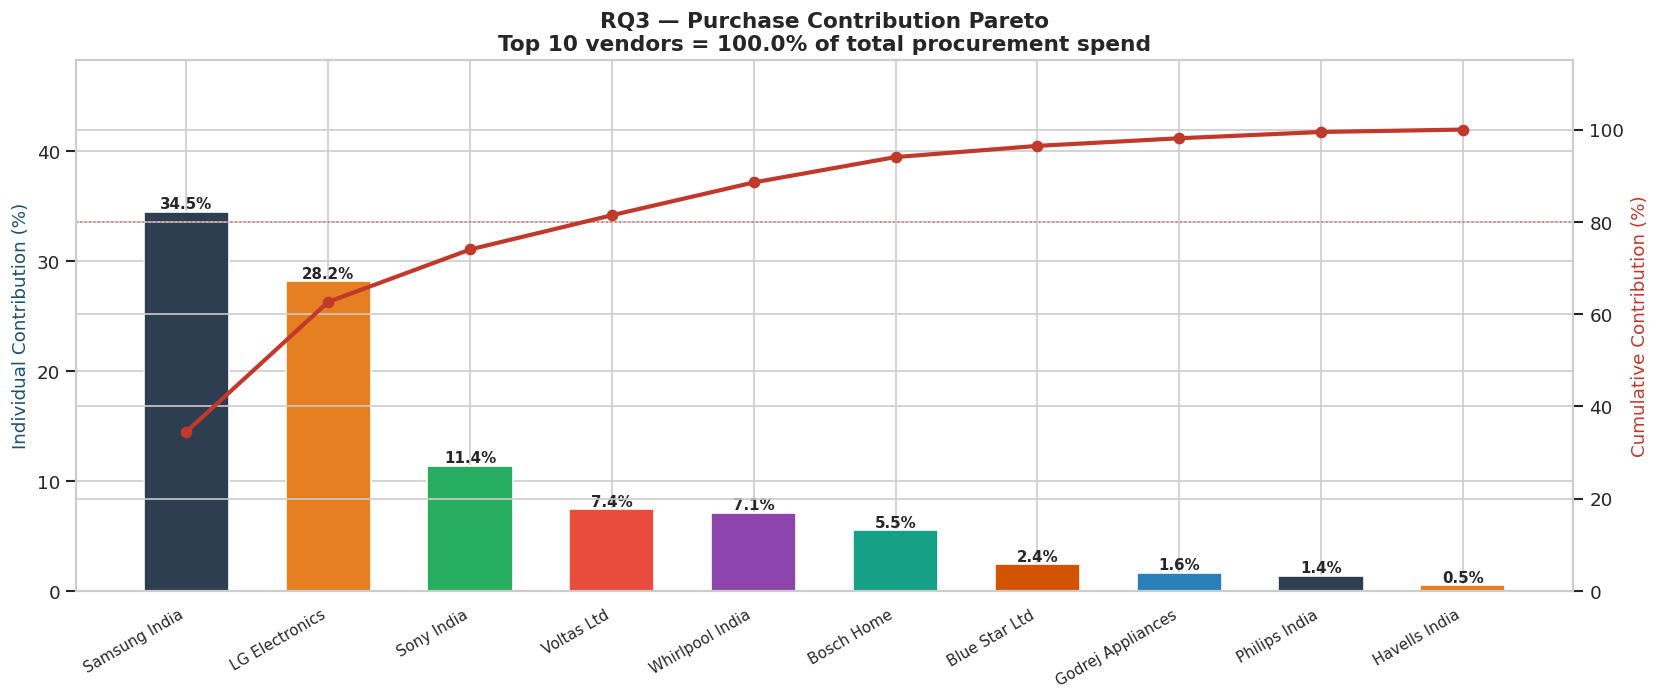

Chart saved ✅


In [48]:
# Cell 10 — Pareto Chart (Purchase Contribution)
# Research Question 3: How concentrated is our procurement?
# Pareto principle: typically 20% of vendors = 80% of spend
# A Pareto chart = bar chart + cumulative line on same plot

# Aggregate purchase dollars per vendor
vendor_purch = (
    df.groupby('VendorName')['TotalPurchaseDollars']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

total_spend = vendor_purch['TotalPurchaseDollars'].sum()

# Calculate each vendor's % contribution
vendor_purch['PctContrib'] = vendor_purch['TotalPurchaseDollars'] / total_spend * 100

# Cumulative sum: add each vendor's % to the running total
vendor_purch['CumPct'] = vendor_purch['PctContrib'].cumsum()

top10 = vendor_purch.head(10)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart on primary axis (ax1)
bars = ax1.bar(
    range(len(top10)),
    top10['PctContrib'],
    color=PALETTE[:len(top10)],
    edgecolor='white', width=0.6
)
ax1.set_ylabel('Individual Contribution (%)', color='#1B4F72', fontsize=11)
ax1.set_xticks(range(len(top10)))
ax1.set_xticklabels(top10['VendorName'], rotation=30, ha='right', fontsize=9)
ax1.set_ylim(0, top10['PctContrib'].max() * 1.4)

# Add percentage labels on bars
for bar, pct in zip(bars, top10['PctContrib']):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        f'{pct:.1f}%',
        ha='center', fontsize=9, fontweight='bold'
    )

# Cumulative line on secondary axis (ax2)
# twinx() creates a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(
    range(len(top10)),
    top10['CumPct'],
    color='#C0392B', marker='o', lw=2.5,
    label='Cumulative %'
)
ax2.axhline(80, color='#C0392B', ls=':', lw=1, alpha=0.6)  # 80% reference line
ax2.set_ylabel('Cumulative Contribution (%)', color='#C0392B', fontsize=11)
ax2.set_ylim(0, 115)

top10_total = top10['PctContrib'].sum()
ax1.set_title(
    f'RQ3 — Purchase Contribution Pareto\n'
    f'Top 10 vendors = {top10_total:.1f}% of total procurement spend',
    fontweight='bold', fontsize=13
)
plt.tight_layout()
plt.savefig('../outputs/06_pareto_chart.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

Average unit price by order size:
  OrderSize  UnitPurchasePrice
0     Small            15260.0
1    Medium            32800.0
2     Large            20200.0

Unit cost reduction (Small → Large): -32.4%


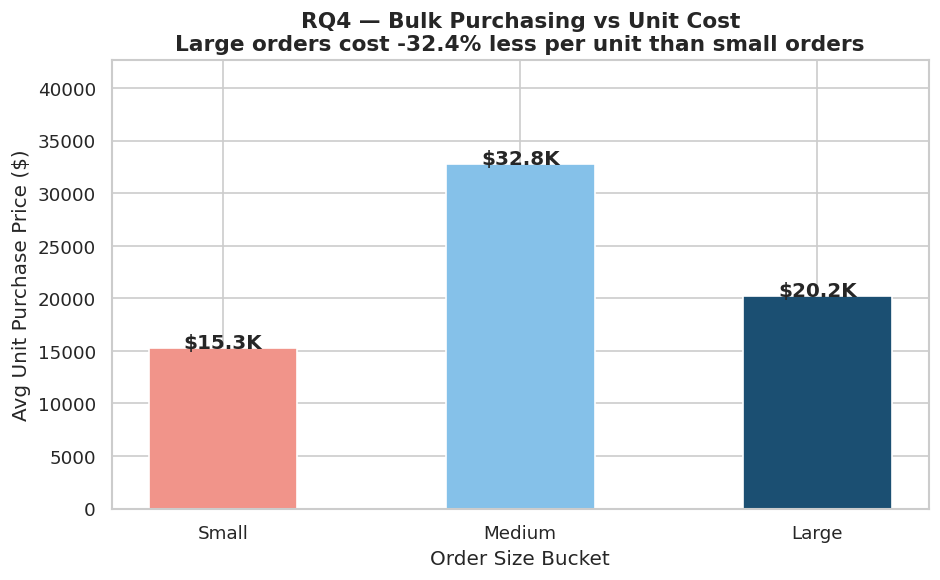

Chart saved ✅


In [49]:
# Cell 11 — Bulk Purchasing Effect (Bar Chart)
# Research Question 4: Does buying in bulk reduce our unit cost?
# This tells us whether to consolidate orders

data = df.dropna(subset=['UnitPurchasePrice', 'TotalPurchaseQty']).copy()

# pd.qcut divides data into equal-sized buckets based on quantiles
# q=3 → three equal groups: bottom 33%, middle 33%, top 33%
data['OrderSize'] = pd.qcut(
    data['TotalPurchaseQty'],
    q=3,
    labels=['Small', 'Medium', 'Large']
)

# Average unit price per order size bucket
bulk_summary = (
    data.groupby('OrderSize', observed=True)['UnitPurchasePrice']
    .mean()
    .reset_index()
)

print("Average unit price by order size:")
print(bulk_summary)

# Calculate % saving from Small → Large
small_price = bulk_summary[bulk_summary['OrderSize']=='Small']['UnitPurchasePrice'].values[0]
large_price = bulk_summary[bulk_summary['OrderSize']=='Large']['UnitPurchasePrice'].values[0]
saving_pct  = (small_price - large_price) / small_price * 100
print(f"\nUnit cost reduction (Small → Large): {saving_pct:.1f}%")

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#F1948A', '#85C1E9', '#1B4F72']  # light to dark = small to large

bars = ax.bar(
    bulk_summary['OrderSize'],
    bulk_summary['UnitPurchasePrice'],
    color=colors, width=0.5, edgecolor='white'
)

for bar, val in zip(bars, bulk_summary['UnitPurchasePrice']):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        fmt_dollars(val),
        ha='center', fontweight='bold', fontsize=12
    )

ax.set_xlabel('Order Size Bucket', fontsize=12)
ax.set_ylabel('Avg Unit Purchase Price ($)', fontsize=12)
ax.set_title(
    f'RQ4 — Bulk Purchasing vs Unit Cost\n'
    f'Large orders cost {saving_pct:.1f}% less per unit than small orders',
    fontweight='bold', fontsize=13
)
ax.set_ylim(0, bulk_summary['UnitPurchasePrice'].max() * 1.3)
plt.tight_layout()
plt.savefig('../outputs/07_bulk_discount.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

Total capital locked in unsold inventory: $0


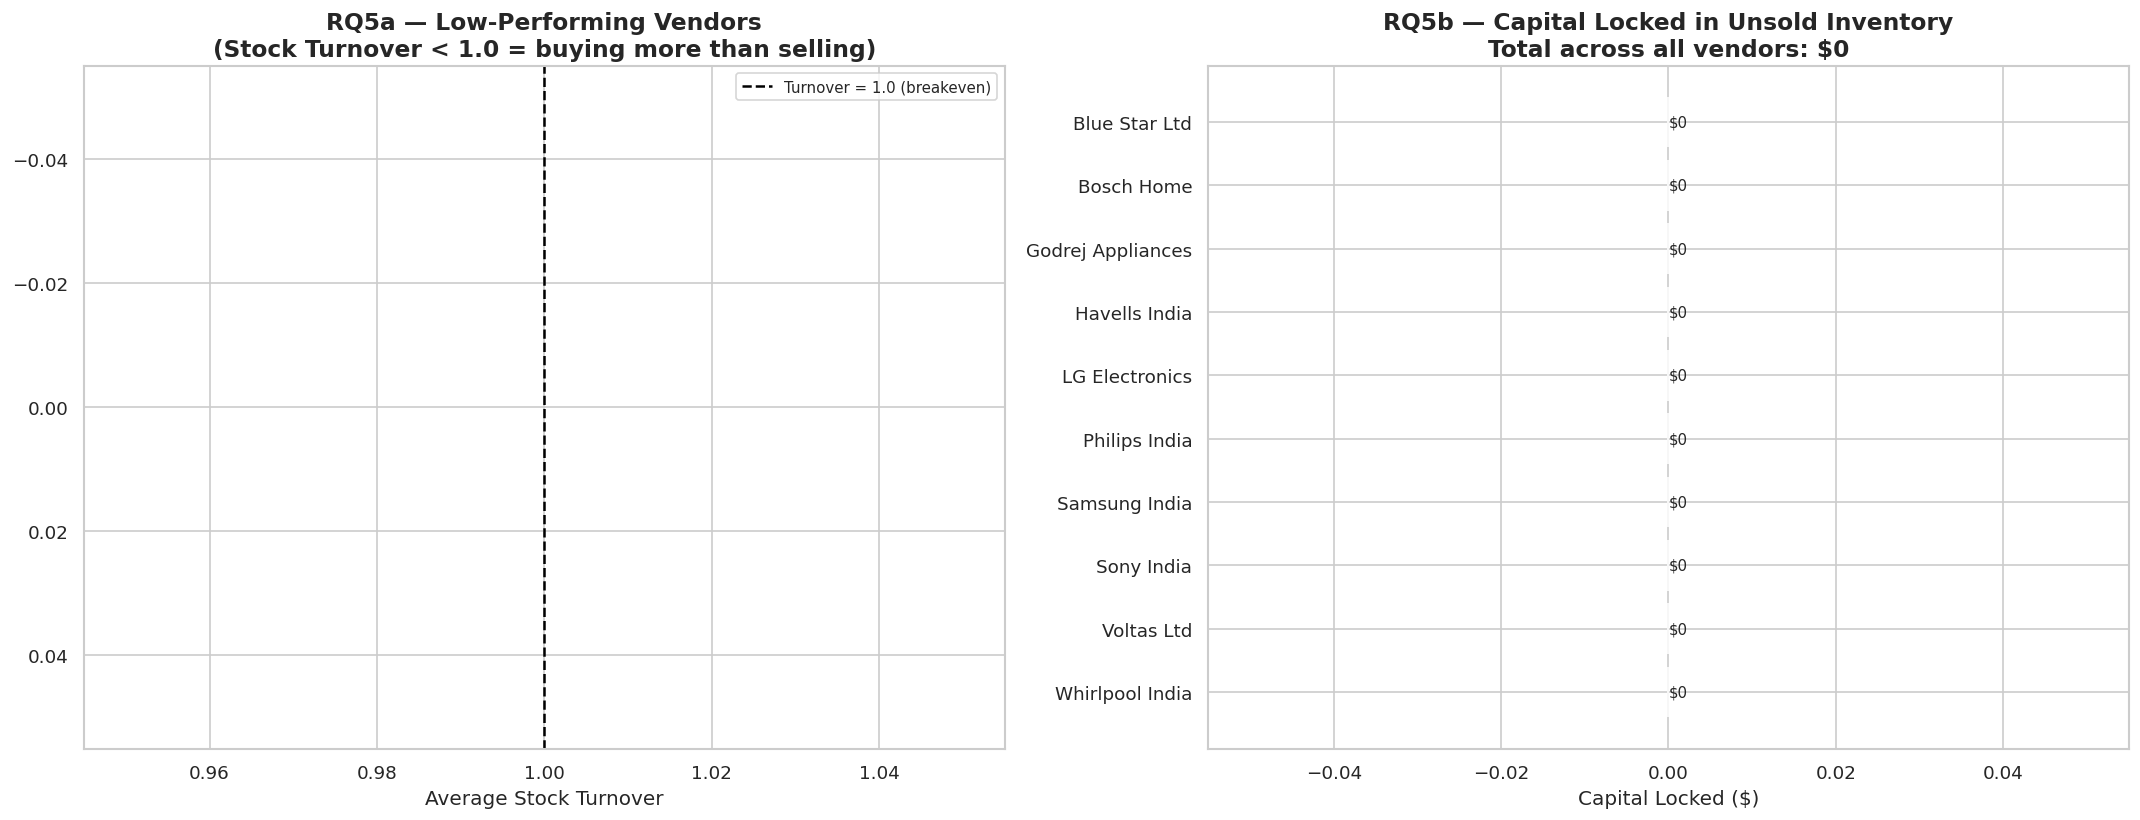

Chart saved ✅


In [50]:
# Cell 12 — Inventory Health (Low Turnover + Locked Capital)
# Research Question 5: Who has poor stock turnover?
# Stock turnover < 1 = vendor sold fewer units than they purchased
# = inventory piling up = capital locked up = problem!

# Filter vendors with turnover < 1 (underperformers)
low_turnover = (
    df[df['StockTurnover'] < 1]
    .groupby('VendorName', as_index=False)
    .agg(
        AvgTurnover  =('StockTurnover', 'mean'),
        LockedCapital=('UnsoldCapital', 'sum')
    )
    .sort_values('AvgTurnover')
    .head(10)
)

# Capital locked up by ALL vendors
locked_capital = (
    df.groupby('VendorName')['UnsoldCapital']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

total_locked = df['UnsoldCapital'].sum()
print(f"Total capital locked in unsold inventory: {fmt_dollars(total_locked)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Left: Low Turnover Funnel (horizontal bar sorted worst first) ---
colors_red = sns.color_palette('Reds_r', len(low_turnover))
ax1.barh(low_turnover['VendorName'], low_turnover['AvgTurnover'], color=colors_red)
ax1.invert_yaxis()
ax1.axvline(1.0, color='black', ls='--', lw=1.5, label='Turnover = 1.0 (breakeven)')
ax1.set_xlabel('Average Stock Turnover')
ax1.set_title('RQ5a — Low-Performing Vendors\n(Stock Turnover < 1.0 = buying more than selling)',
              fontweight='bold')
ax1.legend(fontsize=9)

for i, (_, row) in enumerate(low_turnover.iterrows()):
    ax1.text(row['AvgTurnover'] + 0.01, i,
             f'{row["AvgTurnover"]:.2f}', va='center', fontsize=9, fontweight='bold')

# --- Right: Capital Locked ---
colors_blue = sns.color_palette('Blues_r', len(locked_capital))
bars2 = ax2.barh(locked_capital['VendorName'], locked_capital['UnsoldCapital'], color=colors_blue)
ax2.invert_yaxis()
ax2.set_xlabel('Capital Locked ($)')
ax2.set_title(f'RQ5b — Capital Locked in Unsold Inventory\nTotal across all vendors: {fmt_dollars(total_locked)}',
              fontweight='bold')

for bar, val in zip(bars2, locked_capital['UnsoldCapital']):
    ax2.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height() / 2,
             fmt_dollars(val), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/08_inventory_health.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

Total capital locked in unsold inventory: $0


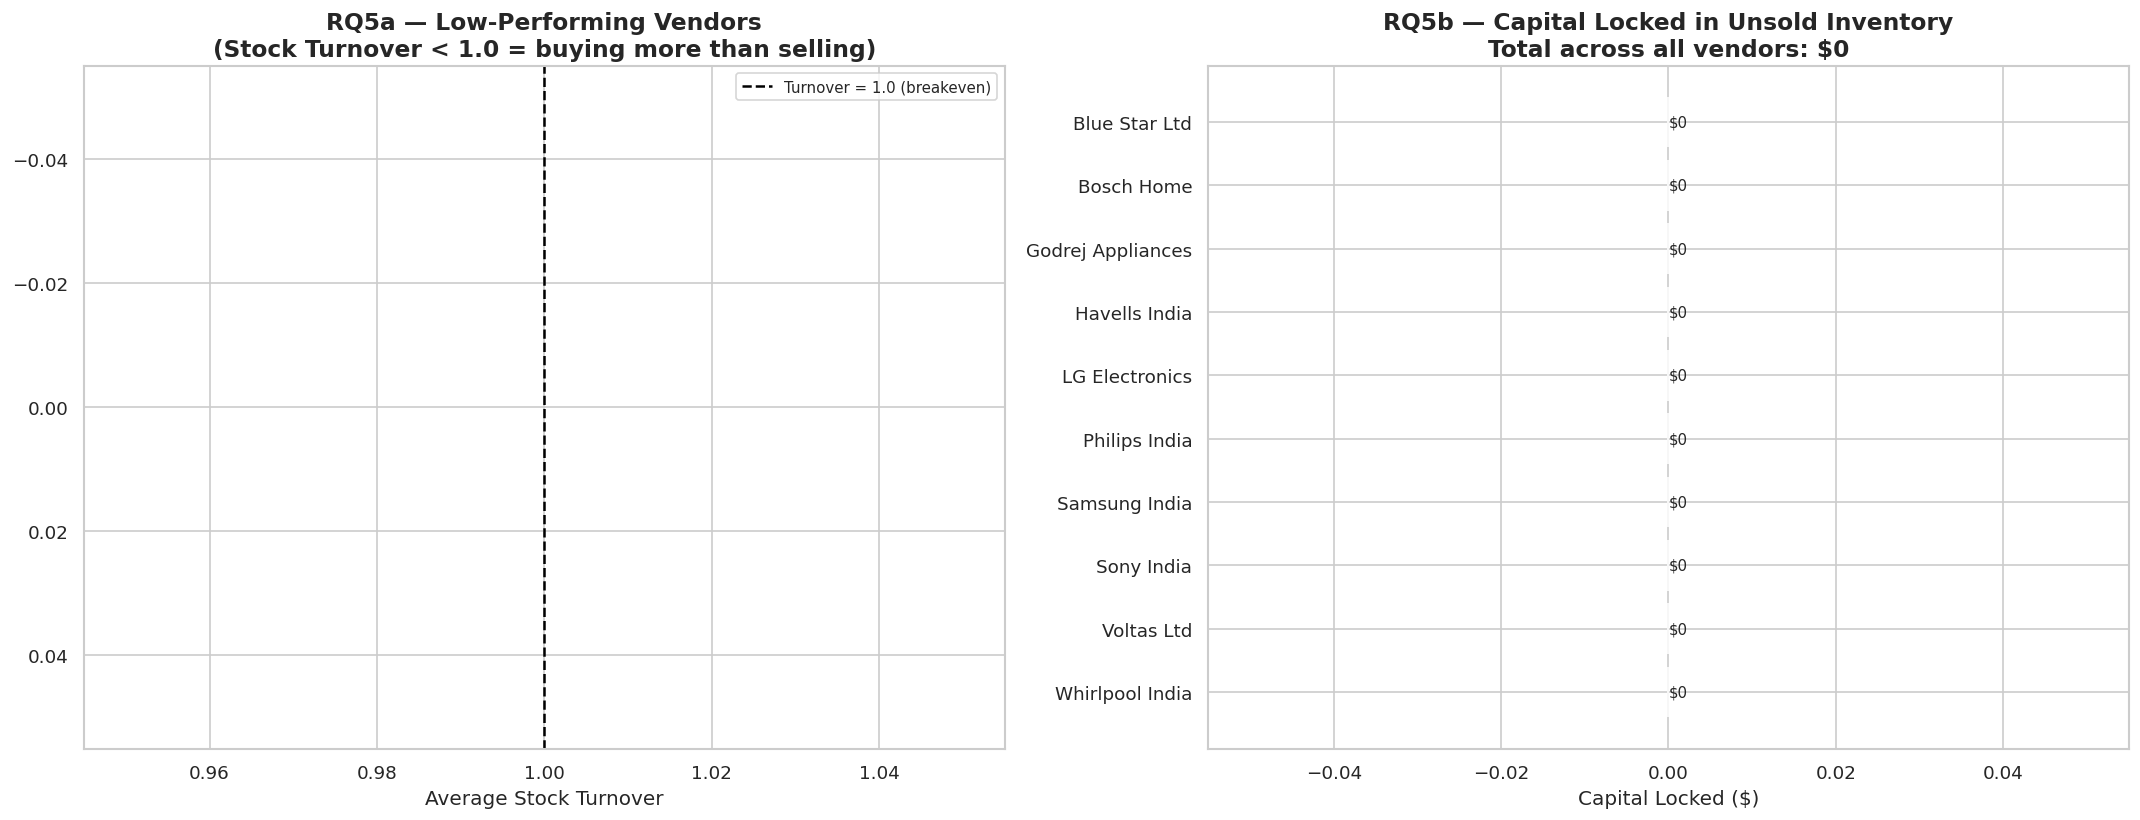

Chart saved ✅


In [51]:
# Cell 12 — Inventory Health (Low Turnover + Locked Capital)
# Research Question 5: Who has poor stock turnover?
# Stock turnover < 1 = vendor sold fewer units than they purchased
# = inventory piling up = capital locked up = problem!

# Filter vendors with turnover < 1 (underperformers)
low_turnover = (
    df[df['StockTurnover'] < 1]
    .groupby('VendorName', as_index=False)
    .agg(
        AvgTurnover  =('StockTurnover', 'mean'),
        LockedCapital=('UnsoldCapital', 'sum')
    )
    .sort_values('AvgTurnover')
    .head(10)
)

# Capital locked up by ALL vendors
locked_capital = (
    df.groupby('VendorName')['UnsoldCapital']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

total_locked = df['UnsoldCapital'].sum()
print(f"Total capital locked in unsold inventory: {fmt_dollars(total_locked)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Left: Low Turnover Funnel (horizontal bar sorted worst first) ---
colors_red = sns.color_palette('Reds_r', len(low_turnover))
ax1.barh(low_turnover['VendorName'], low_turnover['AvgTurnover'], color=colors_red)
ax1.invert_yaxis()
ax1.axvline(1.0, color='black', ls='--', lw=1.5, label='Turnover = 1.0 (breakeven)')
ax1.set_xlabel('Average Stock Turnover')
ax1.set_title('RQ5a — Low-Performing Vendors\n(Stock Turnover < 1.0 = buying more than selling)',
              fontweight='bold')
ax1.legend(fontsize=9)

for i, (_, row) in enumerate(low_turnover.iterrows()):
    ax1.text(row['AvgTurnover'] + 0.01, i,
             f'{row["AvgTurnover"]:.2f}', va='center', fontsize=9, fontweight='bold')

# --- Right: Capital Locked ---
colors_blue = sns.color_palette('Blues_r', len(locked_capital))
bars2 = ax2.barh(locked_capital['VendorName'], locked_capital['UnsoldCapital'], color=colors_blue)
ax2.invert_yaxis()
ax2.set_xlabel('Capital Locked ($)')
ax2.set_title(f'RQ5b — Capital Locked in Unsold Inventory\nTotal across all vendors: {fmt_dollars(total_locked)}',
              fontweight='bold')

for bar, val in zip(bars2, locked_capital['UnsoldCapital']):
    ax2.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height() / 2,
             fmt_dollars(val), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/08_inventory_health.png', bbox_inches='tight')
plt.show()
print("Chart saved ✅")

   Store  total_transactions  total_units_sold  total_revenue  \
0      3               10038             65559   2.665011e+09   
1      6               10046             65405   2.663779e+09   
2      5               10014             65189   2.642106e+09   
3      1               10005             65163   2.635252e+09   
4     10               10075             65048   2.631214e+09   
5      2               10068             65226   2.619400e+09   
6      9                9837             64132   2.599114e+09   
7      8               10080             65134   2.598640e+09   
8      7                9923             63935   2.584299e+09   
9      4                9914             63876   2.559469e+09   

   avg_selling_price  
0       40605.870444  
1       40741.474118  
2       40460.795357  
3       40216.395005  
4       40459.351118  
5       40227.983408  
6       40683.199070  
7       39902.135971  
8       40271.350553  
9       39970.965197  


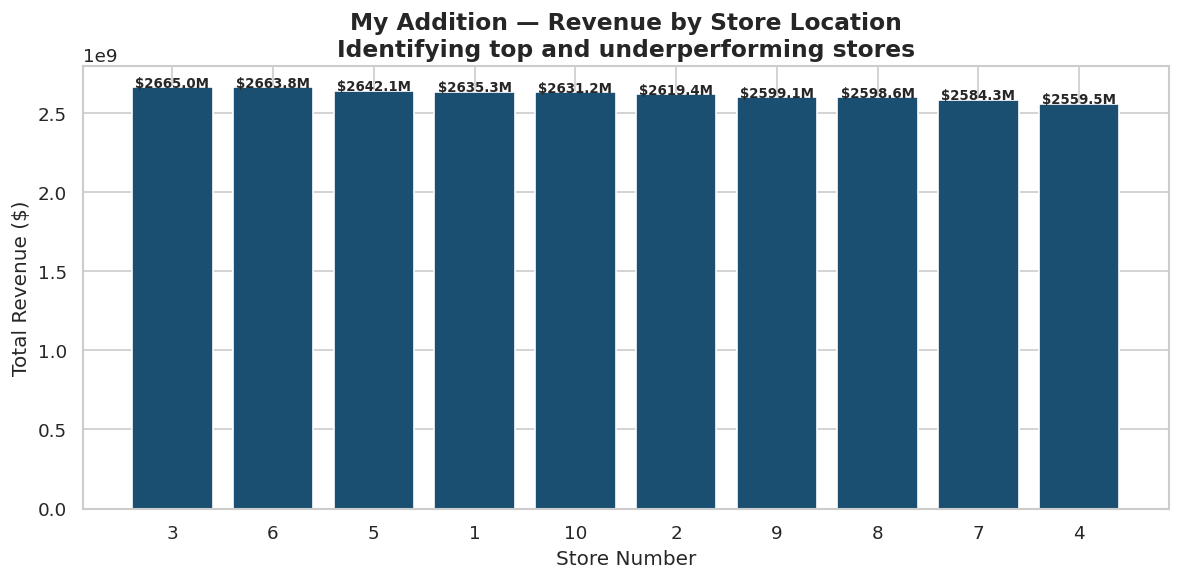

My custom chart saved ✅


In [52]:
# MY OWN RESEARCH QUESTION
# Which stores are generating the most sales?
# (I added this myself to understand geographic performance)

# The sales table has store-level data — let's use it
store_sales = pd.read_sql("""
    SELECT 
        Store,
        COUNT(*)           AS total_transactions,
        SUM(SalesQuantity) AS total_units_sold,
        SUM(SalesDollars)  AS total_revenue,
        AVG(SalesPrice)    AS avg_selling_price
    FROM sales
    GROUP BY Store
    ORDER BY total_revenue DESC
""", conn)

print(store_sales)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    store_sales['Store'].astype(str),
    store_sales['total_revenue'],
    color='#1B4F72', edgecolor='white'
)
ax.set_xlabel('Store Number')
ax.set_ylabel('Total Revenue ($)')
ax.set_title('My Addition — Revenue by Store Location\nIdentifying top and underperforming stores',
             fontweight='bold')

for bar, val in zip(bars, store_sales['total_revenue']):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 100,
            fmt_dollars(val),
            ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/12_store_performance.png', bbox_inches='tight')
plt.show()
print("My custom chart saved ✅")